L'objectif de ce notebook est d'appliquer une méthode de segmetnation d'images, afin de regrouper des pixels similaires.
L'algorithme utilisé ici est :
    
- Unsupervised Superpixel Segmentation via la méthode `Felzenszwalb`

Exercice : aller voir la documentation

In [ ]:
!gdown https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF -O USE_CASE_2.zip

Downloading...
From: https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF
To: /content/USE_CASE_2.zip
100% 152M/152M [00:01<00:00, 115MB/s]


In [ ]:
#!unzip USE_CASE_2.zip

# Unsupervised Superpixel Segementation

The objective of this notebook to evaluate the performance of unsupervised superpixel segmentation algorithms on satellite images. This is considered as a non-supervised object segmentation.

In [ ]:
# ! pip3 install scikit-image

In [ ]:
import tifffile as tiff
import numpy as np
from osgeo import gdal,gdal_array,osr,ogr
from skimage.segmentation import felzenszwalb,mark_boundaries
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
# from utils import array2raster,create_directory
import os
from os.path import join
from osgeo import gdal
# %matplotlib notebook

# Functions definition

In [ ]:
def create_directory(folder_name):
    if not os.path.exists(folder_name):
        try:
            os.mkdir(folder_name)
        except OSError as exc:
            if exc.errno!=errno.EEXIST:
                raise

In [ ]:
def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Define path to the two images resulting from the preprocessing step

In [ ]:
img1_path = './USE_CASE_2/image_dataset/training_data/inpainted_img1.tif'
img2_path = './USE_CASE_2/image_dataset/training_data/inpainted_img2.tif'

## Visualize the first image using matplotlib

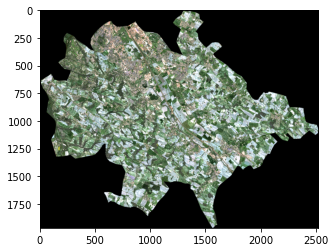

In [ ]:
img1_arr = tiff.imread(img1_path)
plt.figure(1)
plt.imshow(img1_arr[...,0:3])

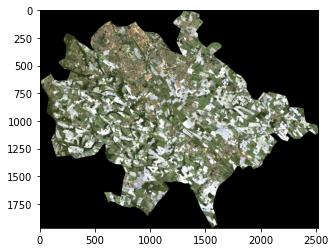

In [ ]:
img2_arr = tiff.imread(img2_path)
plt.figure(11)
plt.imshow(img2_arr[...,0:3])

## Let's perfrom a superpixel segmentation on the first image 
## using the Felzenszwalb algorithm implemented in the Scikit-image library 
https://github.com/RaphaelGervillie/Superpixel

In [ ]:
segments_fz = felzenszwalb(img1_arr, scale=100, sigma=0.5, min_size=50)

# min_size = il n'y pas de groupe avec moins de 50 pixels dedans.
# c'est les parametres par défaut là

# sigma utilise dans la phase de pre-processing (Gaussian kernel)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
segments_fz

array([[   0,    0,    0, ...,    5,    5,    5],
       [   0,    0,    0, ...,    5,    5,    5],
       [   0,    0,    0, ...,    5,    5,    5],
       ...,
       [3542, 3542, 3542, ..., 8290, 8290, 8290],
       [3542, 3542, 3542, ..., 8290, 8290, 8290],
       [3542, 3542, 3542, ..., 8290, 8290, 8290]])

In [35]:
img1_arr.shape

(1967, 2520, 4)

In [34]:
segments_fz.shape

(1967, 2520)

In [37]:
len(np.unique(segments_fz))

12331

In [38]:
1967*2520

4956840

## Visualize the segmentation results using the matplotlib by overlaying the segments on the original image

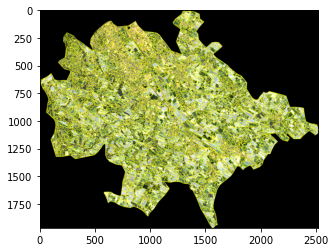

In [ ]:
plt.figure(2)
plt.imshow(mark_boundaries(img1_arr[...,0:3], segments_fz))
# on affiche en superposant

## Inspect the dimensions of the segments. It is identical to the spatial dimensions of the input image.

In [ ]:
img1_arr.shape

(1967, 2520, 4)

In [ ]:
segments_fz.shape

(1967, 2520)

In [ ]:
segments_fz

array([[   0,    0,    0, ...,    5,    5,    5],
       [   0,    0,    0, ...,    5,    5,    5],
       [   0,    0,    0, ...,    5,    5,    5],
       ...,
       [3542, 3542, 3542, ..., 8290, 8290, 8290],
       [3542, 3542, 3542, ..., 8290, 8290, 8290],
       [3542, 3542, 3542, ..., 8290, 8290, 8290]])

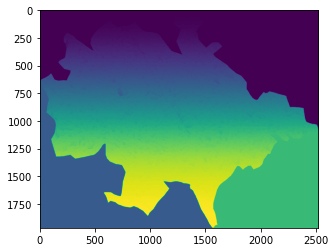

In [ ]:
plt.figure(15)
plt.imshow(segments_fz)
plt.show()
# chaque pixel a un id est identifie

## Exract features for each segment. 
## In here, we will use the mean and standard deviation of the pixels inside each segment

In [ ]:
## ATTENTION : prend beaucoup de temps !!!

features = {}
for (i, segVal) in enumerate(np.unique(segments_fz)): # segVa=id du superpixel et i=l'index du superpixel
    features[i] = {}
    print ("[x] inspecting segment %d" % (i))
    values = img1_arr[segments_fz==segVal] # va recupere les pixels qui ont un meme id
    features[i]['mean'] = np.mean(values,axis=0)
    features[i]['std'] = np.std(values,axis=0)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] inspecting segment 7331
[x] inspecting segment 7332
[x] inspecting segment 7333
[x] inspecting segment 7334
[x] inspecting segment 7335
[x] inspecting segment 7336
[x] inspecting segment 7337
[x] inspecting segment 7338
[x] inspecting segment 7339
[x] inspecting segment 7340
[x] inspecting segment 7341
[x] inspecting segment 7342
[x] inspecting segment 7343
[x] inspecting segment 7344
[x] inspecting segment 7345
[x] inspecting segment 7346
[x] inspecting segment 7347
[x] inspecting segment 7348
[x] inspecting segment 7349
[x] inspecting segment 7350
[x] inspecting segment 7351
[x] inspecting segment 7352
[x] inspecting segment 7353
[x] inspecting segment 7354
[x] inspecting segment 7355
[x] inspecting segment 7356
[x] inspecting segment 7357
[x] inspecting segment 7358
[x] inspecting segment 7359
[x] inspecting segment 7360
[x] inspecting segment 7361
[x] inspecting segment 7362
[x] inspecting segment 736

In [ ]:
len(np.unique(segments_fz))

12331

In [ ]:
features # il y a 4 valeurs car il y a 4 bandes

{0: {'mean': array([0., 0., 0., 0.], dtype=float32),
  'std': array([0., 0., 0., 0.], dtype=float32)},
 1: {'mean': array([0.0002586 , 0.00024354, 0.00023573, 0.00023281], dtype=float32),
  'std': array([0.00798653, 0.0074986 , 0.00727985, 0.00707767], dtype=float32)},
 2: {'mean': array([0.45204294, 0.53892636, 0.39843956, 0.8305077 ], dtype=float32),
  'std': array([0.19416326, 0.15707466, 0.20186734, 0.17025961], dtype=float32)},
 3: {'mean': array([0., 0., 0., 0.], dtype=float32),
  'std': array([0., 0., 0., 0.], dtype=float32)},
 4: {'mean': array([0., 0., 0., 0.], dtype=float32),
  'std': array([0., 0., 0., 0.], dtype=float32)},
 5: {'mean': array([0., 0., 0., 0.], dtype=float32),
  'std': array([0., 0., 0., 0.], dtype=float32)},
 6: {'mean': array([0.30395576, 0.37503552, 0.29137632, 0.56067514], dtype=float32),
  'std': array([0.06712631, 0.05852853, 0.06465436, 0.10426361], dtype=float32)},
 7: {'mean': array([0.66224074, 0.7051725 , 0.7211207 , 0.49290618], dtype=float32),
  

In [ ]:
features[0].keys()

dict_keys(['mean', 'std'])

In [21]:
i = 0
tmp = features[i]
tmp

{'mean': array([0., 0., 0., 0.], dtype=float32),
 'std': array([0., 0., 0., 0.], dtype=float32)}

In [22]:
tmp.keys()

dict_keys(['mean', 'std'])

In [23]:
for i in range (len(features)):
    tmp = features[i]
    if 'mean' not in tmp.keys():
        print(i)
        print(features)

## Create two arrays, one associated with the mean and one with the standard deviation

In [24]:
mean_arr = [features[x]['mean'] for x  in range (len(features))]
mean_arr = np.array(mean_arr)

In [25]:
mean_arr

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [2.5859702e-04, 2.4354161e-04, 2.3572716e-04, 2.3280793e-04],
       [4.5204294e-01, 5.3892636e-01, 3.9843956e-01, 8.3050770e-01],
       ...,
       [6.0413480e-01, 7.0999265e-01, 5.5008304e-01, 9.0434629e-01],
       [6.7384046e-01, 7.2771674e-01, 6.6446716e-01, 6.6906106e-01],
       [7.3290133e-01, 8.1444782e-01, 8.4355664e-01, 5.6651539e-01]],
      dtype=float32)

In [26]:
std_arr = [features[x]['std'] for x  in range (len(features))]
std_arr = np.array(std_arr)

In [27]:
std_arr

array([[0.        , 0.        , 0.        , 0.        ],
       [0.00798653, 0.0074986 , 0.00727985, 0.00707767],
       [0.19416326, 0.15707466, 0.20186734, 0.17025961],
       ...,
       [0.1696793 , 0.1526501 , 0.15800108, 0.08259201],
       [0.10025541, 0.06181339, 0.12202774, 0.09973858],
       [0.10735861, 0.1022464 , 0.12837796, 0.05553455]], dtype=float32)

## Inspect the histogram of the mean and standard deviation features

(array([[  84.,  138., 1304., 2359., 2348., 1875., 1543., 1382.,  782.,
          516.],
        [  84.,    9.,  185., 1469., 2654., 2755., 1794., 1448., 1195.,
          738.],
        [  89.,  259., 1808., 2575., 2339., 1573.,  911.,  973., 1090.,
          714.],
        [  94.,   20.,   14.,   77.,  988., 3041., 3232., 2745., 1484.,
          636.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 4 Lists of Patches objects>)

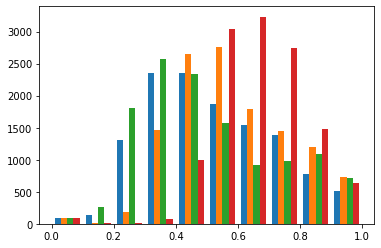

In [28]:
plt.figure(3)
plt.hist(mean_arr)

(array([[2.360e+02, 1.955e+03, 3.361e+03, 2.598e+03, 1.836e+03, 1.427e+03,
         7.170e+02, 1.720e+02, 2.600e+01, 3.000e+00],
        [3.290e+02, 2.519e+03, 4.036e+03, 2.884e+03, 1.821e+03, 6.120e+02,
         1.170e+02, 1.200e+01, 1.000e+00, 0.000e+00],
        [3.280e+02, 2.105e+03, 3.314e+03, 2.761e+03, 2.080e+03, 1.289e+03,
         3.670e+02, 7.200e+01, 1.200e+01, 3.000e+00],
        [6.460e+02, 2.990e+03, 3.442e+03, 3.285e+03, 1.516e+03, 3.740e+02,
         6.300e+01, 1.000e+01, 4.000e+00, 1.000e+00]]),
 array([0.        , 0.03339204, 0.06678408, 0.10017612, 0.13356815,
        0.1669602 , 0.20035224, 0.23374428, 0.2671363 , 0.30052835,
        0.3339204 ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

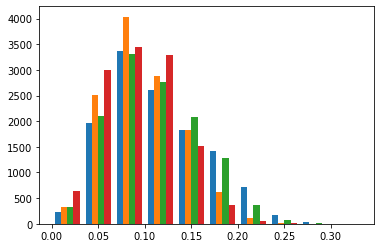

In [29]:
plt.figure(4)
plt.hist(std_arr)

## Create a feature matrix where we concatenate the mean and std arrays

In [30]:
feature_arr = np.zeros((len(features),8),dtype=np.float32)
feature_arr[:,0:4] = np.copy(mean_arr)
feature_arr[:,4:] = np.copy(std_arr)

In [31]:
feature_arr = np.zeros((len(features),8),dtype=np.float32)
feature_arr[:,0:4] = np.copy(mean_arr)
feature_arr[:,4:] = np.copy(std_arr)

In [32]:
feature_arr.shape

(12331, 8)

In [33]:
feature_arr

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.5859702e-04, 2.4354161e-04, 2.3572716e-04, ..., 7.4985963e-03,
        7.2798491e-03, 7.0776688e-03],
       [4.5204294e-01, 5.3892636e-01, 3.9843956e-01, ..., 1.5707466e-01,
        2.0186734e-01, 1.7025961e-01],
       ...,
       [6.0413480e-01, 7.0999265e-01, 5.5008304e-01, ..., 1.5265010e-01,
        1.5800108e-01, 8.2592010e-02],
       [6.7384046e-01, 7.2771674e-01, 6.6446716e-01, ..., 6.1813388e-02,
        1.2202774e-01, 9.9738576e-02],
       [7.3290133e-01, 8.1444782e-01, 8.4355664e-01, ..., 1.0224640e-01,
        1.2837796e-01, 5.5534545e-02]], dtype=float32)

## We will use the Mini-batch Kmeans for clustering since we have a large dataset

In [39]:
kmeans = MiniBatchKMeans(n_clusters=6,random_state=0,batch_size=100)
number_patches = int(len(features)/100)
print (number_patches)
for p in range(number_patches):
    if p!=number_patches-1:
         kmeans = kmeans.partial_fit(feature_arr[p*100:(p+1)*100,:])
    else:
         kmean = kmeans.partial_fit(feature_arr[p*100:,:])

123


In [40]:
labels = kmeans.predict(feature_arr)

In [41]:
labels

array([2, 2, 3, ..., 3, 4, 0], dtype=int32)

In [42]:
print(len(features), '\n', len(labels))

12331 
 12331


## Assign the Kmeans labels to the segments

In [43]:
## ATTENTION : prend 1 minute

label_arr = np.zeros_like(segments_fz)
for (i, segVal) in enumerate(np.unique(segments_fz)):
    print ("[x] filling segment %d" % (i))
    label_arr[segments_fz==segVal] = labels[i]

    # ona ssocie a chaque pixel contenu dans chaque superpixel la classe de resultat kmeans associe a l'identité du superpixel

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] filling segment 7331
[x] filling segment 7332
[x] filling segment 7333
[x] filling segment 7334
[x] filling segment 7335
[x] filling segment 7336
[x] filling segment 7337
[x] filling segment 7338
[x] filling segment 7339
[x] filling segment 7340
[x] filling segment 7341
[x] filling segment 7342
[x] filling segment 7343
[x] filling segment 7344
[x] filling segment 7345
[x] filling segment 7346
[x] filling segment 7347
[x] filling segment 7348
[x] filling segment 7349
[x] filling segment 7350
[x] filling segment 7351
[x] filling segment 7352
[x] filling segment 7353
[x] filling segment 7354
[x] filling segment 7355
[x] filling segment 7356
[x] filling segment 7357
[x] filling segment 7358
[x] filling segment 7359
[x] filling segment 7360
[x] filling segment 7361
[x] filling segment 7362
[x] filling segment 7363
[x] filling segment 7364
[x] filling segment 7365
[x] filling segment 7366
[x] filling segment 73

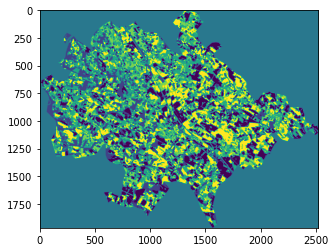

In [44]:
plt.figure(5)
plt.imshow(label_arr)

In [45]:
label_arr[img1_arr[...,0]==0] = -1
# les nodata on les mets a -1

In [48]:
np.unique(label_arr)

array([-1,  0,  1,  2,  3,  4,  5])

## Save the results as a Geotiff

In [49]:
output_path = './USE_CASE_2/image_dataset/superpixel_segmentation'
create_directory(output_path)
output_filename = join(output_path,'superpixel_seg_img1.tif')
dataset = gdal.Open(img1_path) # dataset c'est le template du fichier a sauvegarder
#array2raster(output_filename,dataset,label_arr,'Float32')

## Use the segments to extract features from the second image

In [50]:
## ATTENTON : prend 3 minutes

img2_arr = tiff.imread(img2_path)
features = {}
for (i, segVal) in enumerate(np.unique(segments_fz)):
    features[i] = {}
    print ("[x] inspecting segment %d" % (i))
    values = img2_arr[segments_fz==segVal]
    features[i]['mean'] = np.mean(values,axis=0)
    features[i]['std'] = np.std(values,axis=0)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] inspecting segment 7331
[x] inspecting segment 7332
[x] inspecting segment 7333
[x] inspecting segment 7334
[x] inspecting segment 7335
[x] inspecting segment 7336
[x] inspecting segment 7337
[x] inspecting segment 7338
[x] inspecting segment 7339
[x] inspecting segment 7340
[x] inspecting segment 7341
[x] inspecting segment 7342
[x] inspecting segment 7343
[x] inspecting segment 7344
[x] inspecting segment 7345
[x] inspecting segment 7346
[x] inspecting segment 7347
[x] inspecting segment 7348
[x] inspecting segment 7349
[x] inspecting segment 7350
[x] inspecting segment 7351
[x] inspecting segment 7352
[x] inspecting segment 7353
[x] inspecting segment 7354
[x] inspecting segment 7355
[x] inspecting segment 7356
[x] inspecting segment 7357
[x] inspecting segment 7358
[x] inspecting segment 7359
[x] inspecting segment 7360
[x] inspecting segment 7361
[x] inspecting segment 7362
[x] inspecting segment 736

In [51]:
len(np.unique(segments_fz))

12331

In [52]:
print(len(features))

12331


## Create a feature matrix that contains features from the first and second image

In [53]:
mean_arr = [features[x]['mean'] for x  in range (len(features))]
mean_arr = np.array(mean_arr)
std_arr = [features[x]['std'] for x  in range (len(features))]
std_arr = np.array(std_arr)
feature_arr2 = np.zeros((len(features),8),dtype=np.float32)
feature_arr2[:,0:4] = np.copy(mean_arr)
feature_arr2[:,4:] = np.copy(std_arr)

In [54]:
feature_arr2.shape

(12331, 8)

In [55]:
global_features = np.zeros((len(features),16),dtype=np.float32)
global_features[:,0:8] = np.copy(feature_arr)
global_features[:,8:] = np.copy(feature_arr2)

In [56]:
global_features.shape

(12331, 16)

## Apply clustering to the global feature matrix

In [57]:
kmeans = MiniBatchKMeans(n_clusters=6,random_state=0,batch_size=100)
number_patches = int(len(features)/100)
print (number_patches)
for p in range(number_patches):
    if p!=number_patches-1:
         kmeans = kmeans.partial_fit(global_features[p*100:(p+1)*100,:])
    else:
         kmean = kmeans.partial_fit(global_features[p*100:,:])

123


In [58]:
## ATTENTION : prend 1 minute

labels = kmeans.predict(global_features)
label_arr2 = np.zeros_like(segments_fz)
for (i, segVal) in enumerate(np.unique(segments_fz)):
    print ("[x] filling segment %d" % (i))
    label_arr2[segments_fz==segVal] = labels[i]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[x] filling segment 7331
[x] filling segment 7332
[x] filling segment 7333
[x] filling segment 7334
[x] filling segment 7335
[x] filling segment 7336
[x] filling segment 7337
[x] filling segment 7338
[x] filling segment 7339
[x] filling segment 7340
[x] filling segment 7341
[x] filling segment 7342
[x] filling segment 7343
[x] filling segment 7344
[x] filling segment 7345
[x] filling segment 7346
[x] filling segment 7347
[x] filling segment 7348
[x] filling segment 7349
[x] filling segment 7350
[x] filling segment 7351
[x] filling segment 7352
[x] filling segment 7353
[x] filling segment 7354
[x] filling segment 7355
[x] filling segment 7356
[x] filling segment 7357
[x] filling segment 7358
[x] filling segment 7359
[x] filling segment 7360
[x] filling segment 7361
[x] filling segment 7362
[x] filling segment 7363
[x] filling segment 7364
[x] filling segment 7365
[x] filling segment 7366
[x] filling segment 73

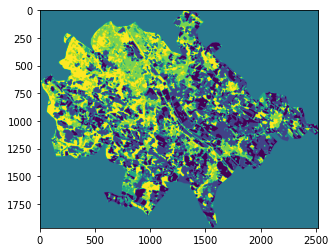

In [59]:
plt.figure(6)
plt.imshow(label_arr2)

In [61]:
label_arr2[img1_arr[...,0]==0] = -1
output_path = './USE_CASE_2/image_dataset/superpixel_segmentation'
#create_directory(output_path)
output_filename = join(output_path,'superpixel_seg_img1_img2.tif')
dataset = gdal.Open(img1_path)
#array2raster(output_filename,dataset,label_arr2,'Float32')